# Q3: Cluster each county by their crime rate, census data, and homelessness

- Phantira (Pearry) Khachichit
- Dai Ling Wu
- Han-Ju (Kylie) Hsieh

**Questions**

Use unsupervised learning to cluster each county by their crime rate, census data, and homelessness to find the similarity of counties.

**Prediction Variable**
- The similarities between counties in the United States based on their crime rate, census data, and homelessness

**Links to raw datasets**
- Crime data: https://www.kaggle.com/mikejohnsonjr/united-states-crime-rates-by-county
- Census data: https://www.kaggle.com/muonneutrino/us-census-demographic-data?select=acs2017_county_data.csv
- Homelessness data: https://catalog.data.gov/dataset/homelessness-count-usa

**The cleaned data files are provided with notebooks**

In [5]:
import numpy as np
import pandas as pd
import seaborn as sns
from datetime import datetime
from matplotlib import pyplot as plt
import plotly.express as px
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, LeaveOneOut, KFold, cross_val_score
from sklearn import metrics
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn import preprocessing
from sklearn import neighbors
from sklearn.metrics import r2_score 
from yellowbrick.cluster import KElbowVisualizer
from yellowbrick.cluster import InterclusterDistance
from yellowbrick.cluster import SilhouetteVisualizer
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

## Read in datasets

In [6]:
census = pd.read_csv('cleaned_census.csv') 
homeless = pd.read_csv('cleaned_homelessness.csv')
crime = pd.read_csv('cleaned_crime.csv')

In [7]:
crime.drop('index',axis = 1, inplace=True)
census.drop('Unnamed: 0', axis = 1, inplace=True)

In [8]:
census['County State'] = census.County +', '+ census.State
crime['County State'] = crime.county +','+ crime.State

## Merge datasets

In [9]:
merged = census.merge(crime, left_on=['County State'], right_on = ['County State'], how = 'inner').merge(
    homeless, left_on='State_x', right_on = 'state')

**Drop duplicate columns**

In [10]:
merged.drop(['CountyId', 'population', 'county', 'State_y', 'state'], axis = 1, inplace = True)

In [ ]:
merged.head()

,State_x,County,TotalPop,Men,Women,Hispanic,White,Black,Native,Asian,...,RAPE,ROBBERY,AGASSLT,BURGLRY,LARCENY,MVTHEFT,ARSON,FIPS_ST,FIPS_CTY,NumberofHomelessness
0,AL,Autauga County,55036,26899,28137,2.7,75.4,18.9,0.3,0.9,...,15,34,87,447,1233,85,108,1,1,21291
1,AL,Baldwin County,203360,99527,103833,4.4,83.1,9.5,0.8,0.7,...,30,76,332,967,3829,192,31,1,3,21291
2,AL,Barbour County,26201,13976,12225,4.2,45.7,47.8,0.2,0.6,...,4,8,36,90,362,21,0,1,5,21291
3,AL,Bibb County,22580,12251,10329,2.4,74.6,22.0,0.4,0.0,...,4,8,36,122,251,27,0,1,7,21291
4,AL,Blount County,57667,28490,29177,9.0,87.4,1.5,0.3,0.1,...,11,9,101,397,865,86,9,1,9,21291


## Visualization

**Correlation**

In [21]:
X = merged[['State_x', 'TotalPop', 'Men', 'Women', 'Black', 'Hispanic', 'Income', 'IncomePerCap', 
            'Poverty', 'Employed', 'Unemployment', 'crime_rate_per_100000', 'NumberofHomelessness']]

<AxesSubplot:>

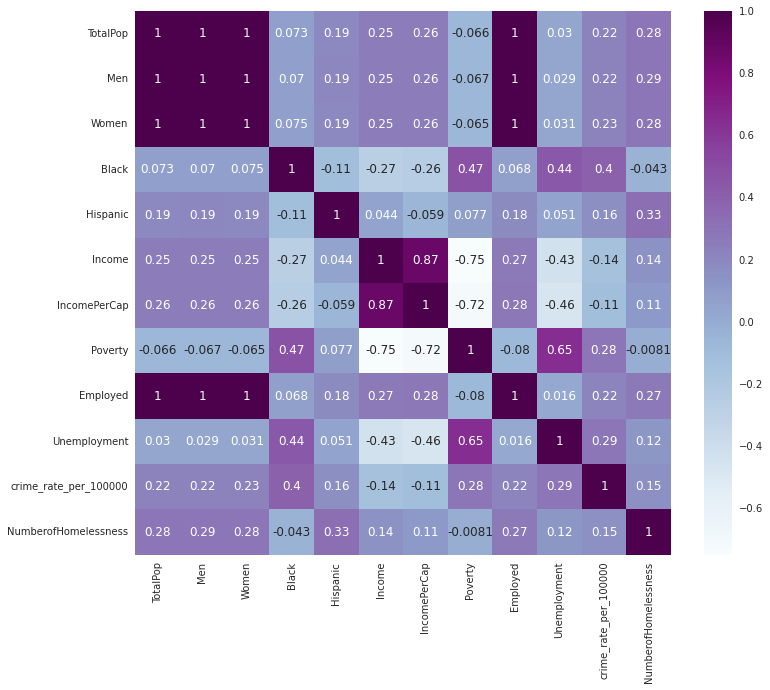

In [24]:
plt.figure(figsize=(12,10))
sns.heatmap(X.corr(), annot=True, cmap="BuPu")

**State vs Number of homelessness**

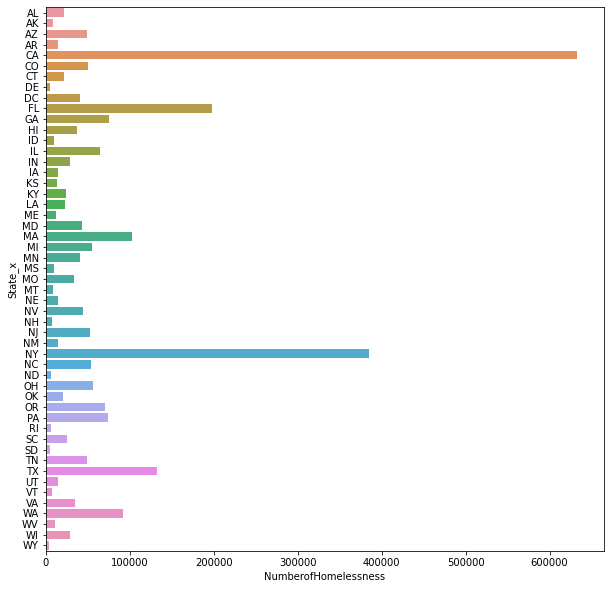

In [ ]:
plt.figure(figsize = (10,10))
sns.barplot(x = 'NumberofHomelessness', y = 'State_x', data = merged)
plt.show()

**Income per capita of counties for each state**

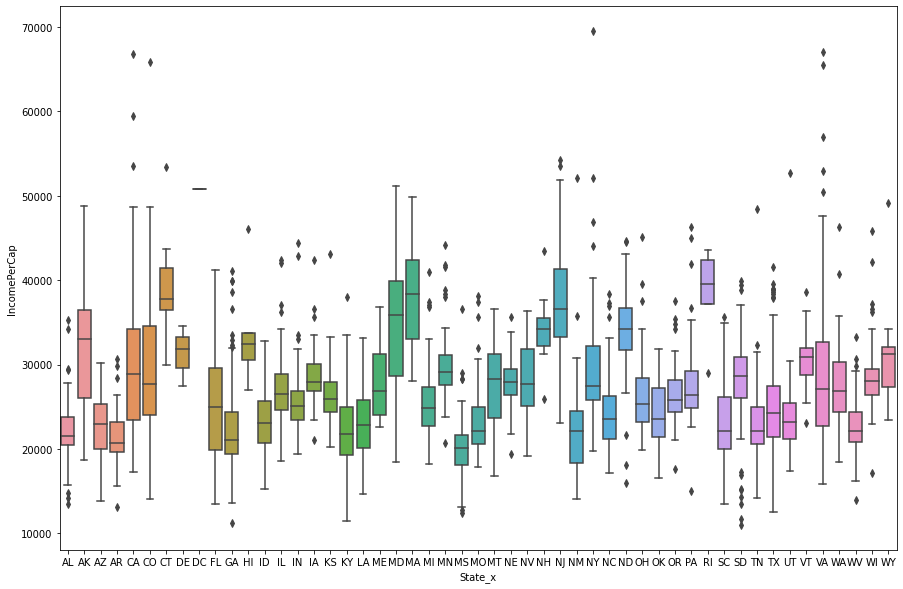

In [ ]:
plt.figure(figsize = (15,10))
sns.boxplot(x = 'State_x', y = 'IncomePerCap', data = merged)
plt.show()

**Crime rate per 100000 people of counties for each state**

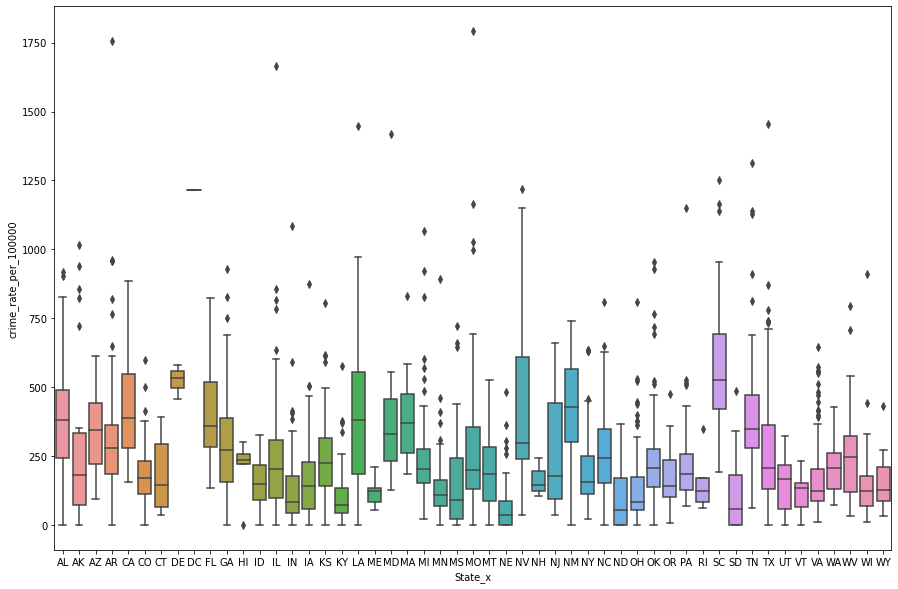

In [ ]:
plt.figure(figsize = (15,10))
sns.boxplot(x = 'State_x', y = 'crime_rate_per_100000', data = merged)
plt.show()

**Unemployment rate of counties for each state**

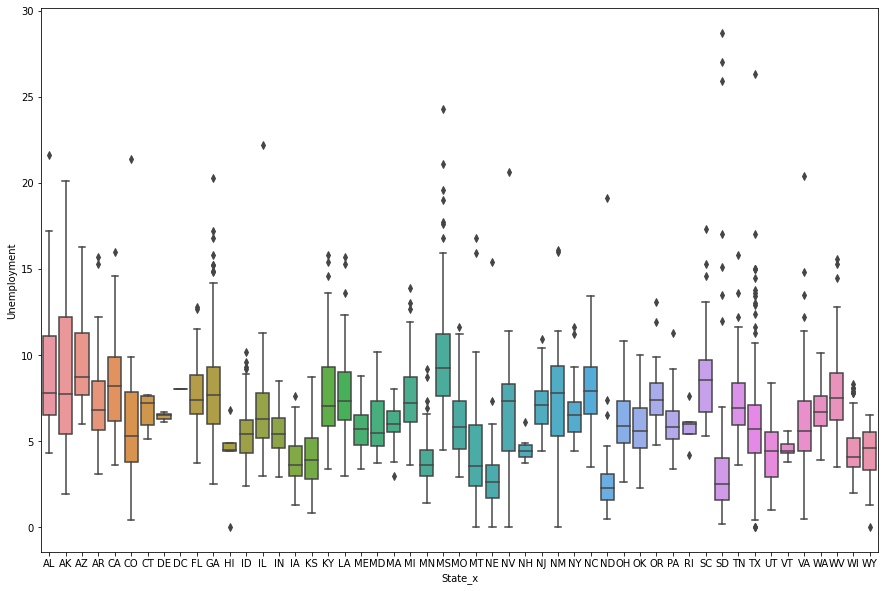

In [ ]:
plt.figure(figsize = (15,10))
sns.boxplot(x = 'State_x', y = 'Unemployment', data = merged)
plt.show()

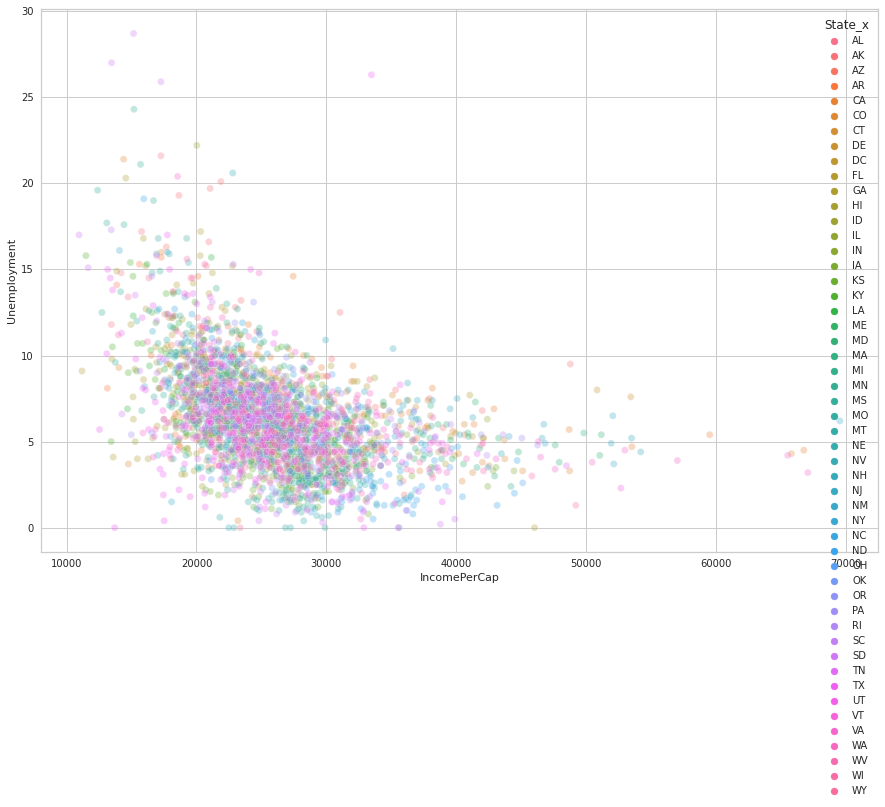

In [12]:
plt.figure(figsize = (15,10))
sns.scatterplot(x = 'IncomePerCap', y = 'Unemployment', data = merged, alpha = 0.3, hue='State_x')
plt.show()

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif


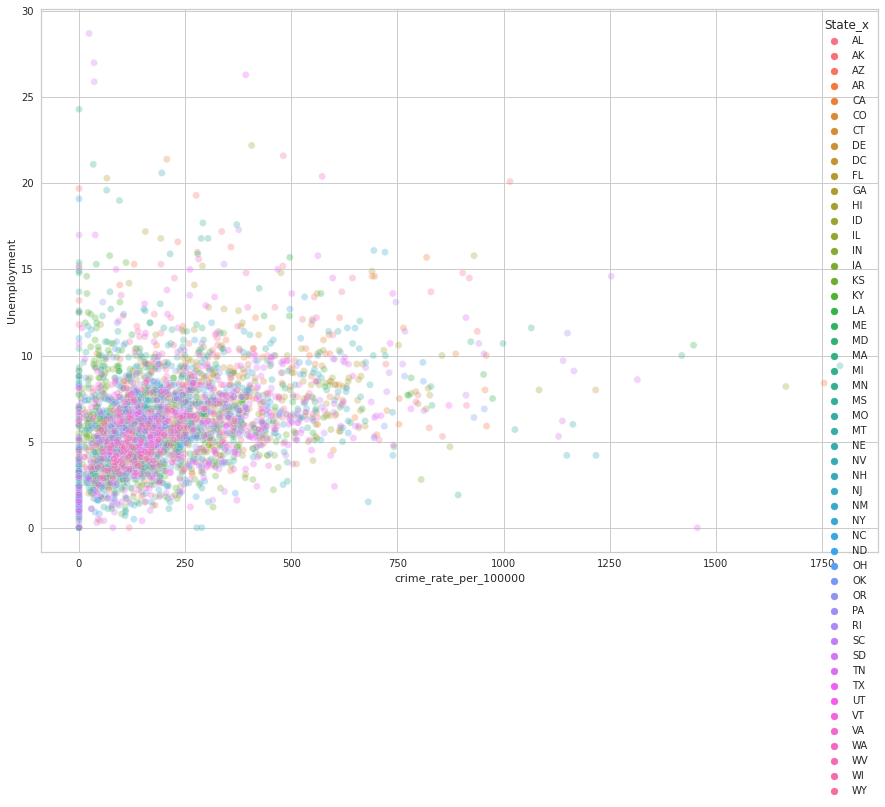

In [11]:
plt.figure(figsize = (15,10))
sns.scatterplot(x = 'crime_rate_per_100000', y = 'Unemployment', data = merged, alpha = 0.3, hue='State_x')
plt.show()

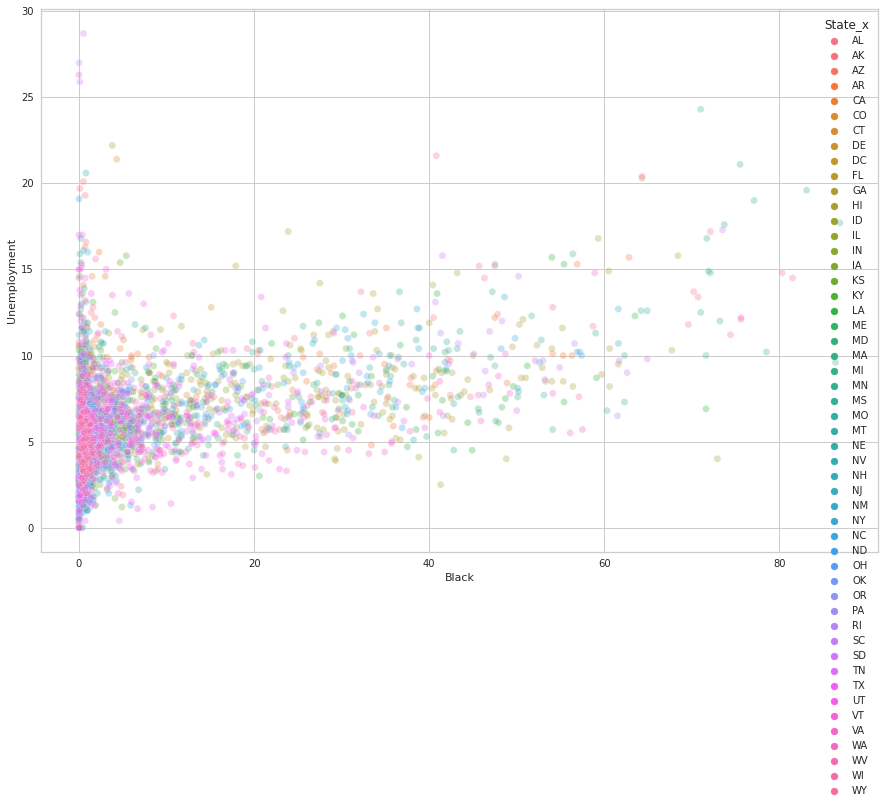

In [13]:
plt.figure(figsize = (15,10))
sns.scatterplot(x = 'Black', y = 'Unemployment', data = merged, alpha = 0.3, hue='State_x')
plt.show()

**Select a subset from all columns and train a preliminary model**

In [ ]:
X = merged[['Unemployment', 'crime_rate_per_100000']]

**Train the Kmeans model**

In [ ]:
model = KMeans(random_state=1)
model.fit(X)
model.labels_

array([6, 6, 0, ..., 4, 4, 4], dtype=int32)

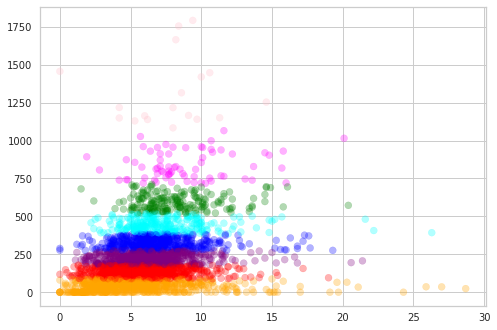

In [ ]:
colors = np.array(["red","green","blue","pink","orange","magenta","purple","cyan"])
plt.scatter(X['Unemployment'], X['crime_rate_per_100000'], c=colors[model.labels_], alpha = 0.3)
plt.show()

/shared-libs/python3.7/py/lib/python3.7/site-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  "X does not have valid feature names, but"


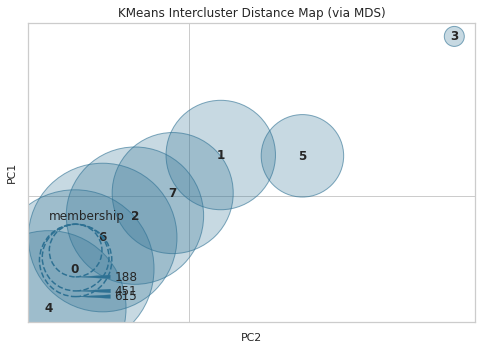

In [ ]:
visualizer = InterclusterDistance(model)
visualizer.fit(X) 
visualizer.show();  

**Find the best k for the KMeans model**

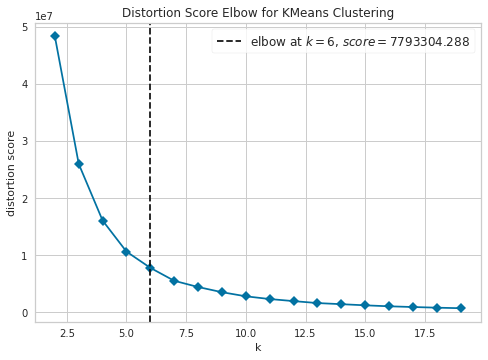

In [ ]:
#Create a Kmeans model
model = KMeans(random_state=1)
#run from k=2 to k=20
visualizer = KElbowVisualizer(model, k=(2,20), timings = False)
visualizer.fit(X)
visualizer.show(); 

The best k is 6. Now use this optimal k to train a new KMeans model and visualize it

In [ ]:
model_tuned = KMeans(random_state=1, n_clusters=6).fit(X)

/shared-libs/python3.7/py/lib/python3.7/site-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  "X does not have valid feature names, but"


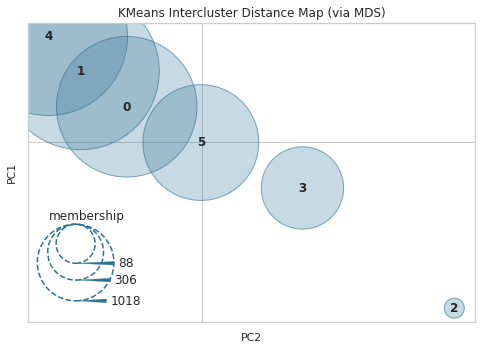

In [ ]:
visualizer = InterclusterDistance(model_tuned)
visualizer.fit(X) 
visualizer.show();  

---

## REFERENCES

**List any references you used to complete your homework. Even if they are one of the books assigned for this class. If this section is incomplete you will be deducted 50% of your final grade from this homework.**

- Lab 2 Jupyter notebook
- Clustering Exercise notebook
- https://www.scikit-yb.org/en/latest/quickstart.html



<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=c62e4f61-5454-4e18-b0e0-542e6e7256b8' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>